## No UPDRS

Rerun the analysis done in [Linear SVC 1/5/2019](2019-01-05_LinearSVC_DataRoundup.ipynb) but this time drop UPDRS:

For cross validation (need both mean and standard deviation) and holdout:
* Accuracy
* Sensitivity
* Specificity
* PPV
* NPV
* Recall
* Precision
* Area Under the Curve
* Support

Also need ROC curve as a list of numbers.

Variable contribution (importance) to models (mean and standard deviation).


**In addition**, look into how to change the threshold for probability scoring

## Imports and Function Definitions

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=verbose)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [3]:
param_grid = {
    "classifier__C": np.logspace(-5, 1, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_data = _data.drop(['UPDRS'], axis=1)

## 1. Control vs. PD/MSA/PSP

In [5]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=42)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   39.2s finished


Best parameters set found on development set:

{'classifier__C': 0.12742749857031321}

Grid scores on development set:

0.542 (+/-0.424) for {'classifier__C': 1.0000000000000001e-05}
0.284 (+/-0.004) for {'classifier__C': 2.06913808111479e-05}
0.445 (+/-0.386) for {'classifier__C': 4.2813323987193957e-05}
0.361 (+/-0.039) for {'classifier__C': 8.8586679041008327e-05}
0.420 (+/-0.064) for {'classifier__C': 0.00018329807108324357}
0.442 (+/-0.058) for {'classifier__C': 0.00037926901907322499}
0.458 (+/-0.050) for {'classifier__C': 0.00078475997035146064}
0.498 (+/-0.097) for {'classifier__C': 0.001623776739188721}
0.555 (+/-0.090) for {'classifier__C': 0.0033598182862837811}
0.601 (+/-0.084) for {'classifier__C': 0.0069519279617756054}
0.630 (+/-0.054) for {'classifier__C': 0.01438449888287663}
0.633 (+/-0.040) for {'classifier__C': 0.029763514416313162}
0.630 (+/-0.040) for {'classifier__C': 0.061584821106602607}
0.641 (+/-0.057) for {'classifier__C': 0.12742749857031321}
0.641 (+/-0.06

In [6]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.290192174911	0.0115545959223
score_time	0.060914516449	0.00158322559997
test_recall	0.633043478261	0.0378635496645
train_recall	0.696956521739	0.0199526850532
test_precision	0.826725184832	0.030178075579
train_precision	0.904147288352	0.00610078111158
test_auc	0.647874396135	0.0352793964537
train_auc	0.755263825032	0.0102034029703
test_specificity	0.826725184832	0.030178075579
train_specificity	0.904147288352	0.00610078111158
test_npv	0.633043478261	0.0378635496645
train_npv	0.696956521739	0.0199526850532
test_accuracy	0.641358695652	0.0283686727924
train_accuracy	0.730079504658	0.0134945217585


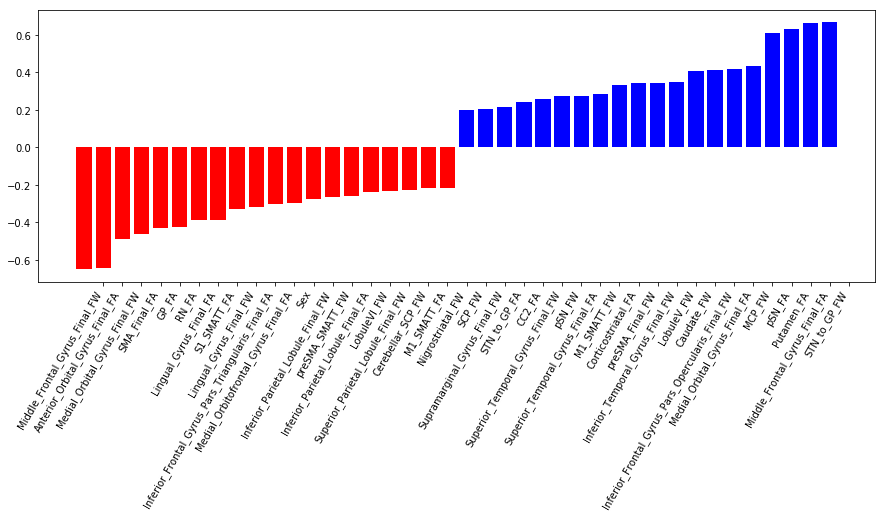

Age	-0.0150201726537
Sex	-0.296443945659
aSN_FA	-0.0782637866242
Caudate_FA	0.0140792696868
CC2_FA	0.239904698371
GP_FA	-0.428644624931
LobuleVI_FA	0.0501635916887
LobuleV_FA	0.0508793465809
MCP_FA	0.0557198042033
pSN_FA	0.610080666722
Putamen_FA	0.629871239235
SCP_FA	-0.00272851940648
STN_FA	-0.138984355821
Thalamus_FA	0.0653669509881
Vermis_FA	-0.139247433131
RN_FA	-0.424638699476
PPN_FA	0.083346130787
Dentate_FA	0.00641438981368
CC1_FA	-0.083124462799
aSN_FW	-0.0418901830297
Caudate_FW	0.406260238338
CC2_FW	0.0788359751216
GP_FW	-0.0188405556734
LobuleVI_FW	-0.239520895578
LobuleV_FW	0.346910383822
MCP_FW	0.434431351741
pSN_FW	0.273083170255
Putamen_FW	-0.118074564871
SCP_FW	0.199248702179
STN_FW	0.16157255585
Thalamus_FW	-0.022134954079
Vermis_FW	-0.214798498125
RN_FW	0.0249077175969
PPN_FW	0.139053070668
Dentate_FW	-0.124947845419
CC1_FW	-0.184506941815
Angular_Gyrus_Final_FA	-0.0339751281489
Anterior_Orbital_Gyrus_Final_FA	-0.644953625954
Calcarine_Sulcus_Final_FA	-0.001823988777

In [7]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.37      0.68      0.48        50
          1       0.85      0.62      0.72       151

avg / total       0.73      0.64      0.66       201



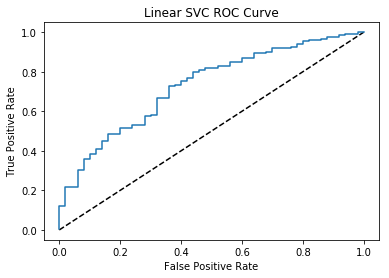

0.0 0.00662251655629
0.0 0.119205298013
0.02 0.119205298013
0.02 0.218543046358
0.06 0.218543046358
0.06 0.304635761589
0.08 0.304635761589
0.08 0.35761589404
0.1 0.35761589404
0.1 0.384105960265
0.12 0.384105960265
0.12 0.41059602649
0.14 0.41059602649
0.14 0.450331125828
0.16 0.450331125828
0.16 0.483443708609
0.2 0.483443708609
0.2 0.516556291391
0.24 0.516556291391
0.24 0.529801324503
0.28 0.529801324503
0.28 0.576158940397
0.3 0.576158940397
0.3 0.582781456954
0.32 0.582781456954
0.32 0.668874172185
0.36 0.668874172185
0.36 0.728476821192
0.38 0.728476821192
0.38 0.735099337748
0.4 0.735099337748
0.4 0.754966887417
0.42 0.754966887417
0.42 0.76821192053
0.44 0.76821192053
0.44 0.801324503311
0.46 0.801324503311
0.46 0.807947019868
0.48 0.807947019868
0.48 0.82119205298
0.52 0.82119205298
0.52 0.827814569536
0.56 0.827814569536
0.56 0.847682119205
0.6 0.847682119205
0.6 0.867549668874
0.64 0.867549668874
0.64 0.894039735099
0.68 0.894039735099
0.68 0.900662251656
0.7 0.900662251656

In [8]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

In [9]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=42)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.6s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Grid scores on development set:

0.540 (+/-0.396) for {'classifier__C': 1.0000000000000001e-05}
0.728 (+/-0.022) for {'classifier__C': 2.06913808111479e-05}
0.817 (+/-0.077) for {'classifier__C': 4.2813323987193957e-05}
0.821 (+/-0.097) for {'classifier__C': 8.8586679041008327e-05}
0.817 (+/-0.090) for {'classifier__C': 0.00018329807108324357}
0.829 (+/-0.096) for {'classifier__C': 0.00037926901907322499}
0.850 (+/-0.100) for {'classifier__C': 0.00078475997035146064}
0.864 (+/-0.102) for {'classifier__C': 0.001623776739188721}
0.871 (+/-0.066) for {'classifier__C': 0.0033598182862837811}
0.879 (+/-0.064) for {'classifier__C': 0.0069519279617756054}
0.886 (+/-0.058) for {'classifier__C': 0.01438449888287663}
0.883 (+/-0.059) for {'classifier__C': 0.029763514416313162}
0.866 (+/-0.075) for {'classifier__C': 0.061584821106602607}
0.864 (+/-0.075) for {'classifier__C': 0.12742749857031321}
0.859 (+/-0.06

In [10]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0758708000183	0.00187862925648
score_time	0.0216910839081	0.000598293246878
test_recall	0.796974789916	0.0655539749774
train_recall	0.878594515692	0.00578281311786
test_precision	0.822011523908	0.0642989940979
train_precision	0.878973343001	0.0155816095108
test_auc	0.860441625611	0.0349379109461
train_auc	0.913502071437	0.00250241385814
test_specificity	0.822011523908	0.0642989940979
train_specificity	0.878973343001	0.0155816095108
test_npv	0.796974789916	0.0655539749774
train_npv	0.878594515692	0.00578281311786
test_accuracy	0.886214713156	0.0287915140517
train_accuracy	0.927588727496	0.00418349518559


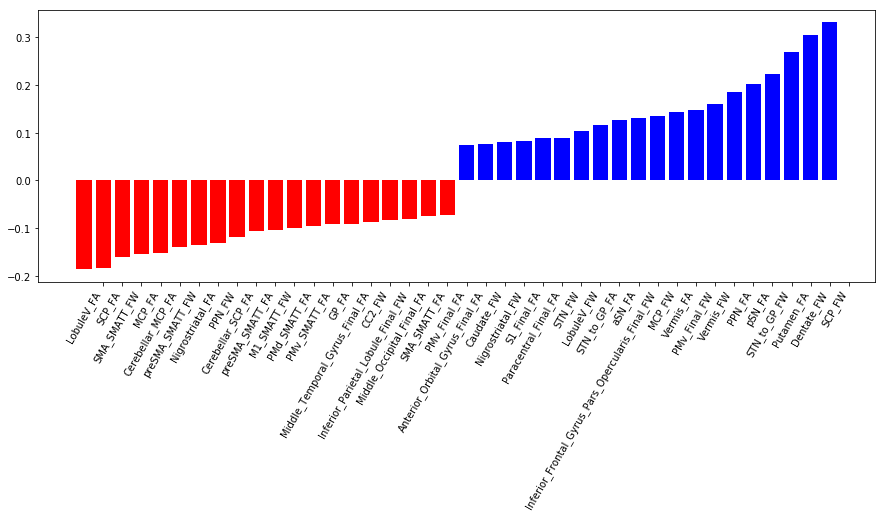

Age	-0.00012094109485
Sex	0.0
aSN_FA	0.127297031871
Caudate_FA	-0.0351895951972
CC2_FA	0.0290867298665
GP_FA	-0.0920705116485
LobuleVI_FA	0.0556986980323
LobuleV_FA	-0.186563449733
MCP_FA	-0.154775925712
pSN_FA	0.202117957423
Putamen_FA	0.268933622409
SCP_FA	-0.182987705068
STN_FA	0.0103436592984
Thalamus_FA	-0.00956109243474
Vermis_FA	0.14413659953
RN_FA	-0.0257200022863
PPN_FA	0.184317268099
Dentate_FA	0.068832449221
CC1_FA	-0.0224768929775
aSN_FW	0.0421029777859
Caudate_FW	0.0761417848496
CC2_FW	-0.0878637844464
GP_FW	0.0635954761436
LobuleVI_FW	0.0332466047585
LobuleV_FW	0.104293111008
MCP_FW	0.135775974823
pSN_FW	0.0350489629609
Putamen_FW	0.00120766662907
SCP_FW	0.331679743883
STN_FW	0.0893856761388
Thalamus_FW	0.0227257488324
Vermis_FW	0.158967663288
RN_FW	0.0155413823882
PPN_FW	-0.131760788328
Dentate_FW	0.305313909167
CC1_FW	0.0452647949757
Angular_Gyrus_Final_FA	-0.0105960306001
Anterior_Orbital_Gyrus_Final_FA	0.073567259595
Calcarine_Sulcus_Final_FA	-0.0253541229937
Cuneus_F

In [11]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.95      0.89      0.92       107
          1       0.74      0.87      0.80        39

avg / total       0.89      0.88      0.89       146



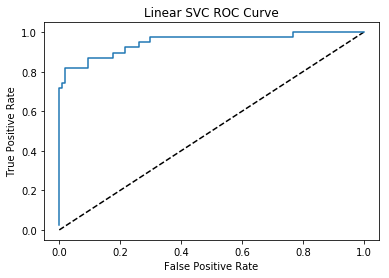

0.0 0.025641025641
0.0 0.717948717949
0.00934579439252 0.717948717949
0.00934579439252 0.74358974359
0.018691588785 0.74358974359
0.018691588785 0.820512820513
0.0934579439252 0.820512820513
0.0934579439252 0.871794871795
0.177570093458 0.871794871795
0.177570093458 0.897435897436
0.214953271028 0.897435897436
0.214953271028 0.923076923077
0.261682242991 0.923076923077
0.261682242991 0.948717948718
0.299065420561 0.948717948718
0.299065420561 0.974358974359
0.766355140187 0.974358974359
0.766355140187 1.0
1.0 1.0


In [12]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

In [13]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=42)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.0s finished


Best parameters set found on development set:

{'classifier__C': 0.001623776739188721}

Grid scores on development set:

0.578 (+/-0.739) for {'classifier__C': 1.0000000000000001e-05}
0.422 (+/-0.739) for {'classifier__C': 2.06913808111479e-05}
0.793 (+/-0.339) for {'classifier__C': 4.2813323987193957e-05}
0.824 (+/-0.046) for {'classifier__C': 8.8586679041008327e-05}
0.824 (+/-0.066) for {'classifier__C': 0.00018329807108324357}
0.816 (+/-0.069) for {'classifier__C': 0.00037926901907322499}
0.829 (+/-0.075) for {'classifier__C': 0.00078475997035146064}
0.847 (+/-0.057) for {'classifier__C': 0.001623776739188721}
0.845 (+/-0.064) for {'classifier__C': 0.0033598182862837811}
0.824 (+/-0.024) for {'classifier__C': 0.0069519279617756054}
0.810 (+/-0.030) for {'classifier__C': 0.01438449888287663}
0.821 (+/-0.021) for {'classifier__C': 0.029763514416313162}
0.814 (+/-0.037) for {'classifier__C': 0.061584821106602607}
0.821 (+/-0.044) for {'classifier__C': 0.12742749857031321}
0.817 (+/-0.0

In [14]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.12776017189	0.00321548333962
score_time	0.0369562625885	0.00126223581531
test_recall	0.494285714286	0.19930491459
train_recall	0.6335839599	0.0933919470082
test_precision	0.400879120879	0.10614531397
train_precision	0.528377616917	0.0656282471793
test_auc	0.695065590593	0.0905772532584
train_auc	0.77432076542	0.029033595297
test_specificity	0.400879120879	0.10614531397
train_specificity	0.528377616917	0.0656282471793
test_npv	0.494285714286	0.19930491459
train_npv	0.6335839599	0.0933919470082
test_accuracy	0.846442676098	0.0287031966086
train_accuracy	0.880627368943	0.0206367560721


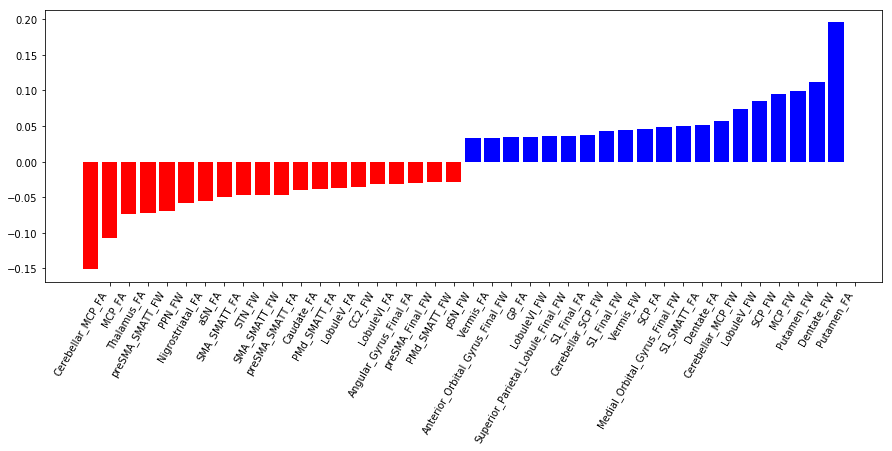

Age	0.00890867144458
Sex	0.0
aSN_FA	-0.0550346465614
Caudate_FA	-0.0400487236265
CC2_FA	0.0130827090058
GP_FA	0.0344402105813
LobuleVI_FA	-0.0318482249544
LobuleV_FA	-0.0376337281789
MCP_FA	-0.107840982364
pSN_FA	0.0332617591773
Putamen_FA	0.195960134863
SCP_FA	0.0458737604012
STN_FA	-0.026917051056
Thalamus_FA	-0.0736380841974
Vermis_FA	0.0334434603331
RN_FA	0.0282197855803
PPN_FA	-0.0277222911438
Dentate_FA	0.0518414984722
CC1_FA	-0.0186155479095
aSN_FW	-0.0200735132815
Caudate_FW	0.0214443569815
CC2_FW	-0.0364870199327
GP_FW	0.0114166321717
LobuleVI_FW	0.0346387271788
LobuleV_FW	0.0740591066395
MCP_FW	0.0952669210545
pSN_FW	-0.0290079939575
Putamen_FW	0.0984958164621
SCP_FW	0.0850971598129
STN_FW	-0.0471402815962
Thalamus_FW	0.0138228073387
Vermis_FW	0.0440384713458
RN_FW	-0.0221107259638
PPN_FW	-0.0691293175694
Dentate_FW	0.111674449125
CC1_FW	0.00608230806336
Angular_Gyrus_Final_FA	-0.0309656709155
Anterior_Orbital_Gyrus_Final_FA	0.00656398115233
Calcarine_Sulcus_Final_FA	0.008322

In [15]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      0.95      0.96       134
          1       0.53      0.67      0.59        12

avg / total       0.93      0.92      0.93       146



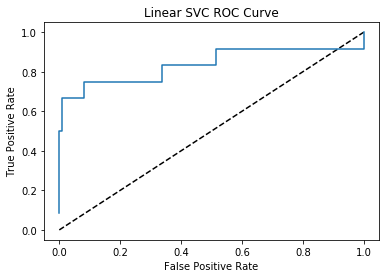

0.0 0.0833333333333
0.0 0.5
0.00746268656716 0.5
0.00746268656716 0.666666666667
0.0820895522388 0.666666666667
0.0820895522388 0.75
0.335820895522 0.75
0.335820895522 0.833333333333
0.514925373134 0.833333333333
0.514925373134 0.916666666667
1.0 0.916666666667
1.0 1.0


In [16]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

In [17]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=42)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring, verbose=1)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.0s finished


Best parameters set found on development set:

{'classifier__C': 0.0069519279617756054}

Grid scores on development set:

0.693 (+/-0.521) for {'classifier__C': 1.0000000000000001e-05}
0.684 (+/-0.372) for {'classifier__C': 2.06913808111479e-05}
0.874 (+/-0.058) for {'classifier__C': 4.2813323987193957e-05}
0.871 (+/-0.077) for {'classifier__C': 8.8586679041008327e-05}
0.871 (+/-0.080) for {'classifier__C': 0.00018329807108324357}
0.871 (+/-0.074) for {'classifier__C': 0.00037926901907322499}
0.888 (+/-0.080) for {'classifier__C': 0.00078475997035146064}
0.905 (+/-0.068) for {'classifier__C': 0.001623776739188721}
0.922 (+/-0.067) for {'classifier__C': 0.0033598182862837811}
0.929 (+/-0.053) for {'classifier__C': 0.0069519279617756054}
0.929 (+/-0.031) for {'classifier__C': 0.01438449888287663}
0.917 (+/-0.040) for {'classifier__C': 0.029763514416313162}
0.905 (+/-0.057) for {'classifier__C': 0.061584821106602607}
0.902 (+/-0.061) for {'classifier__C': 0.12742749857031321}
0.898 (+/-0.

In [18]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0694563865662	0.00442145648659
score_time	0.0201992511749	0.00186035802592
test_recall	0.794761904762	0.123354475114
train_recall	0.892171032821	0.00896106723866
test_precision	0.812119352089	0.0934870620945
train_precision	0.861170548558	0.0215942272162
test_auc	0.876459899749	0.0605945278507
train_auc	0.930657577707	0.00239807610754
test_specificity	0.812119352089	0.0934870620945
train_specificity	0.861170548558	0.0215942272162
test_npv	0.794761904762	0.123354475114
train_npv	0.892171032821	0.00896106723866
test_accuracy	0.92930573175	0.0265296770365
train_accuracy	0.955602349142	0.00323948614088


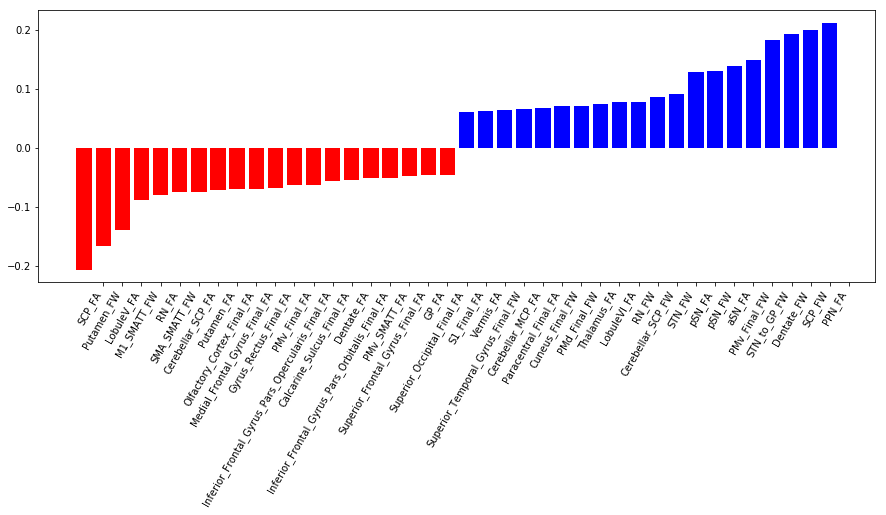

Age	-0.00804996594619
Sex	0.0
aSN_FA	0.138143706665
Caudate_FA	0.0367929934846
CC2_FA	-0.00389964206764
GP_FA	-0.0467521571029
LobuleVI_FA	0.0768224026887
LobuleV_FA	-0.140044052732
MCP_FA	0.0573605834631
pSN_FA	0.127307743107
Putamen_FA	-0.0722443682502
SCP_FA	-0.20713237906
STN_FA	0.00937924559437
Thalamus_FA	0.0732082622197
Vermis_FA	0.0615797887574
RN_FA	-0.0802336859774
PPN_FA	0.211551298436
Dentate_FA	-0.0553820455737
CC1_FA	0.0073537205937
aSN_FW	0.0309104142583
Caudate_FW	-0.0137671922735
CC2_FW	0.0317568816909
GP_FW	-0.00553324431966
LobuleVI_FW	-0.0154798408912
LobuleV_FW	-0.00935283102405
MCP_FW	0.0317665620581
pSN_FW	0.129774507586
Putamen_FW	-0.165917681926
SCP_FW	0.19875894946
STN_FW	0.0911778977427
Thalamus_FW	0.042915189199
Vermis_FW	0.0576934341418
RN_FW	0.0776531013297
PPN_FW	0.0190726226611
Dentate_FW	0.192445606776
CC1_FW	0.00430769275622
Angular_Gyrus_Final_FA	0.0518444830333
Anterior_Orbital_Gyrus_Final_FA	0.0217310757538
Calcarine_Sulcus_Final_FA	-0.0560932202257

In [19]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.97      0.94      0.96       119
          1       0.77      0.89      0.83        27

avg / total       0.94      0.93      0.93       146



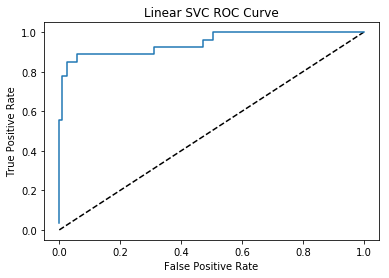

0.0 0.037037037037
0.0 0.555555555556
0.00840336134454 0.555555555556
0.00840336134454 0.777777777778
0.0252100840336 0.777777777778
0.0252100840336 0.851851851852
0.0588235294118 0.851851851852
0.0588235294118 0.888888888889
0.310924369748 0.888888888889
0.310924369748 0.925925925926
0.470588235294 0.925925925926
0.470588235294 0.962962962963
0.504201680672 0.962962962963
0.504201680672 1.0
1.0 1.0


In [20]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)